In [1]:
import jax
from jax import numpy as np
from jax.lax import scan
from jax import vmap, jit
from jax import jacfwd, jacrev
import numpy as onp

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("RdYlBu", 8)
import time

import sys
sys.path.append("../src/")
import network_and_arm
import arm_model
from scipy.interpolate import interp1d

/home/mkp127/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
def cost_stage(x, u, target, lmbda):
    """
    \|state - target\|^2 + lmbda \|u\|^2
    x: (n_states,) angles 
    u: (n_controls, )
    target: (n_states, ) -- To Do
    lmbda: float > 0, penalty on cost
    """
    state_cost = np.sum((x[-4:-2] - target)**2)
    control_cost = np.sum(u**2)
    return state_cost + lmbda * control_cost

def cost_final(x, target):
    """
    \|state - target\|^2 
    """
    return np.sum((x[-4:-2] - target)**2)

# Computes cost over trajectory of ln. (time steps, n_states)
cost_stage_trj = vmap(cost_stage, in_axes=(0,0,0,None))
# Cost of multiple trajectories: (batch size, time steps, n_states)
cost_stage_batch = vmap(cost_stage_trj, in_axes=(0,0,0,None))

def cost_trj(x_trj, u_trj, target_trj, lmbda):
    """
    \sum_t \|state - target\|^2 + lmbda \|u\|^2
    """
    c_stage = cost_stage_trj(x_trj[:-1], u_trj[:-1], target_trj[:-1], lmbda) 
    c_final = cost_final(x_trj[-1], target_trj[-1])
    return c_stage + c_final

cost_trj_batch = vmap(cost_trj, (0,0,0,None))

In [3]:
def cost_stage_grads(x, u, target, lmbda):
    """
    x: (n_states, )
    u: (n_controls,)
    target: (n_states, )
    lmbda: penalty on controls 
    """
    
    dL = jacrev(cost_stage, (0,1)) #l_x, l_u
    d2L = jacfwd(dL, (0,1)) # l_xx etc
    
    l_x, l_u = dL(x, u, target, lmbda)
    d2Ldx, d2Ldu = d2L(x, u, target, lmbda)
    l_xx, l_xu = d2Ldx
    l_ux, l_uu = d2Ldu
    
    return l_x, l_u, l_xx, l_ux, l_uu

# Accepts (batch size, n_states) etc.
cost_stage_grads_batch = vmap(cost_stage_grads, in_axes=(0,0,0,None)) 

def cost_final_grads(x, target):
    """
    x: (n_states, )
    target: (n_states, )
    """
    dL = jacrev(cost_final) #l_x, l_u
    d2L = jacfwd(dL) # l_xx etc
    
    l_x = dL(x, target)
    l_xx = d2L(x, target)
    
    return l_x, l_xx

cost_final_grad_batch = vmap(cost_final_grads, in_axes=(0,0))

In [4]:
def dynamics_grads(x, u):
    """
    f: discrete dynamics x[t+1] = f(x[t], u[t])
    """
    def f(x,u):
        # Grab first output 
        return network_and_arm.discrete_dynamics(x,u)[0]
    
    f_x, f_u = jacfwd(f, (0,1))(x,u)
    return f_x, f_u
  
dynamics_grads_batch = vmap(dynamics_grads, (None,0,0))

In [5]:
### Helpers for LQR approximation ### 

def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    """
    Assemble coefficients for quadratic approximation of value fn
    """
    Q_x = l_x.T + V_x.T @ f_x 
    Q_u = l_u.T + V_x.T @ f_u 
    Q_xx = l_xx + f_x.T @ V_xx @ f_x #
    Q_ux = l_ux + f_u.T @ V_xx @ f_x #
    Q_uu = l_uu + f_u.T @ V_xx @ f_u #
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu


def gains(Q_uu, Q_u, Q_ux):
    """
    Feedback control law u* = k + Kx*
    """
    Q_uu_inv = np.linalg.inv(Q_uu)
    k = np.zeros(Q_u.shape) - Q_uu_inv @ Q_u
    K = np.zeros(Q_ux.shape) - Q_uu_inv @ Q_ux
    return k, K

def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    """
    Quadratic approximation of value function
    """
    V_x  = Q_x.T + Q_u.T @ K + k @ Q_ux + k.T @ Q_uu @ K
    V_xx = Q_xx + K.T @ Q_ux + Q_ux.T @ K + K.T @ Q_uu @ K
    return V_x, V_xx

def expected_cost_reduction(Q_u, Q_uu, k):
    """
    Assuming approximations are true
    """
    return -Q_u.T.dot(k) - 0.5 * k.T.dot(Q_uu.dot(k))

In [6]:
# Forward pass
def discrete_dynamics_affine(xs, inputs):
    """
    Wrapper around arm dynamics fun that pre-computes
    control law
    """
    ut, xt_new = xs[:200], xs[200:]
    xt, ut, kt, Kt = inputs
    ut_new = ut + kt + Kt@(xt_new - xt)
    xt_new2 = network_and_arm.discrete_dynamics(xt_new, ut_new)[0]
    res = np.concatenate((ut_new, xt_new2))
    return res, res 


def forward_pass_scan(x_trj, u_trj, k_trj, K_trj):
    """
    Simulate the system using control law around (x_trj, u_trj)
    defined by k_trj, K_trj
    """
    inputs = (x_trj, u_trj, k_trj, K_trj)
    init = np.concatenate((np.zeros_like(u_trj[0]), x_trj[0]))
    states  = scan(discrete_dynamics_affine, init, (x_trj, u_trj, k_trj, K_trj))[1]
    u_trj_new, x_trj_new = states[:,:200], states[:-1,200:]
    #print(x_trj[0].shape, x_trj_new.shape)
    x_trj_new = np.concatenate((x_trj[0][None], x_trj_new), axis=0)
    return u_trj_new, x_trj_new

forward_pass_jit = jit(forward_pass_scan)
# Batch over x, u, and feedback
forward_pass_batch = jit(vmap(forward_pass_scan, (0,0,0,0))) 

In [7]:
# Backward pass
def step_back_scan(state, inputs, regu, lmbda):
    """
    One step of Bellman iteration, backward in time
    """
    x_t, u_t, target_t = inputs
    k, K, V_x, V_xx = state
    l_x, l_u, l_xx, l_ux, l_uu = cost_stage_grads(x_t, u_t, target_t, lmbda)
    f_x, f_u = dynamics_grads(x_t, u_t)
    Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
    Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
    k, K = gains(Q_uu_regu, Q_u, Q_ux)
    V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
    new_state = (k, K, V_x, V_xx)
    return new_state, new_state

def backward_pass_scan(x_trj, u_trj, target_trj, regu, lmbda):
    """
    Bellman iteration over entire trajectory
    """
    n_x, n_u = x_trj.shape[1], u_trj.shape[1]
    k, K = np.zeros((n_u, )), np.zeros((n_u, n_x))
    l_final_x, l_final_xx = cost_final_grads(x_trj[-1], target_trj[-1])
    V_x = l_final_x
    V_xx = l_final_xx
    # Wrap initial state and inputs for use in scan
    init = (k, K, V_x, V_xx)
    xs = (x_trj, u_trj, target_trj)
    # Loop --- backward in time
    step_fn = lambda state, inputs: step_back_scan(state, inputs, regu, lmbda)
    _, state = scan(step_fn, init, xs, reverse=True)
    k_trj, K_trj, _, _ = state
    return k_trj, K_trj

backward_pass_jit = jit(backward_pass_scan)

In [8]:
def run_ilqr(x0, target_trj, u_trj = None, max_iter=10, regu_init=10, lmbda=1e-1):
    # Main loop
    # First forward rollout
    if u_trj is None:
        N = target_trj.shape[0]
        n_u = 200
        u_trj = onp.random.normal(size=(N, n_u)) * 0.0001
    y_trj, h_trj, q_trj  = network_and_arm.rollout(x0, u_trj)
    x_trj = np.concatenate((y_trj, h_trj, q_trj),1)
    total_cost = cost_trj(x_trj, u_trj, target_trj, lmbda).sum()
    regu = regu_init
    
    cost_trace = [total_cost]
    
    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj = backward_pass_jit(x_trj, u_trj, target_trj, regu, lmbda)
        u_trj_new, x_trj_new = forward_pass_jit(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new, target_trj, lmbda).sum()
        t1 = time.time()
        
        # 
        cost_redu = cost_trace[-1] - total_cost
        cost_trace.append(total_cost)
        
        #if it%1 == 0:
        #    print(it, total_cost, cost_redu)
    return x_trj_new, u_trj_new, np.array(cost_trace)

# To do: use scan and jit?. At least vmap the backward passes etc.
run_ilqr_batch = vmap(run_ilqr, (0, 0, 0, None, None, None))

In [9]:
with open("../data/network_s972356.pickle", 'rb') as handle:
    data = pickle.load(handle)
params = data['params']

N = 200
time_steps = 600
h0 = params['x0']
theta0 = np.array([10, 143.54]) * np.pi/180
q0 = np.concatenate((theta0, np.zeros((2, ))))
q0 = np.repeat(q0[None], axis=0, repeats=8)
x0 = np.concatenate((np.zeros((8, 2)), h0, q0), axis=1)

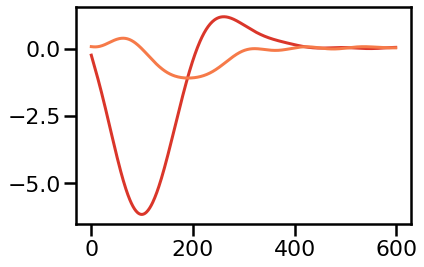

In [10]:
y, h, q = network_and_arm.rollout_batch(x0, np.zeros((8, 600, 200)))
plt.plot(y[0])

dict_keys(['torques', 'positions', 'states'])


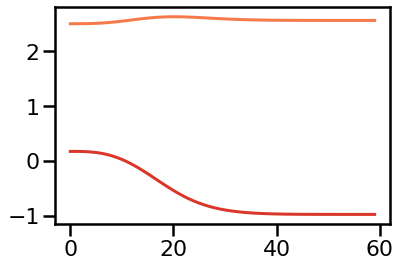

In [11]:
with open('../data/arm_dt10.pickle', 'rb') as handle:
    d = pickle.load(handle)
print(d.keys())
target_trj = d['states'][:,:,:2]
plt.plot(target_trj[0])

In [12]:
x_trj_new, u_trj_new, cost_trace = run_ilqr_batch(x0, q[:,:,:2], None, 2, 1e-4, 1e-4)

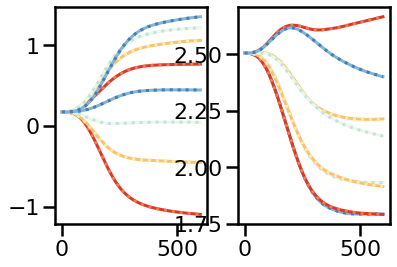

In [13]:
fig, ax = plt.subplots(1,2)
for i in range(8):
    ax[0].plot(x_trj_new[i,:,-4])
    ax[1].plot(x_trj_new[i,:,-3])
    ax[0].plot(q[i,:,0],":")
    ax[1].plot(q[i,:,1],":")

## From wrong init (spont.)

## With prep. 

In [14]:
prep = d['states'][:,0,:2][:,None].repeat(300, 1)
move = interp1d(np.arange(60), d['states'][:,:,:2], axis=1, fill_value='extrapolate')(np.arange(0, 60, 0.1))
target_trj = np.concatenate((prep, move),1)
y_target = arm_model.get_position_batch(target_trj)

In [15]:
h0 = data['xsp'][None].repeat(8, 0)
theta0 = np.array([10, 143.54]) * np.pi/180
q0 = np.concatenate((theta0, np.zeros((2, ))))
q0 = np.repeat(q0[None], axis=0, repeats=8)
x0 = np.concatenate((np.zeros((8, 2)), h0, q0), axis=1)

In [16]:
lmbda = 1e-5
regu = 0
t0 = time.time()
x_trj_new, u_trj_new, cost_trace = run_ilqr_batch(x0, target_trj, None, 1, regu, lmbda)
y_trj = arm_model.get_position_batch(x_trj_new[:,:,-4:-2]) 
t1 = time.time()
print(f"{t1-t0:1.0f}")

42


Visualize result

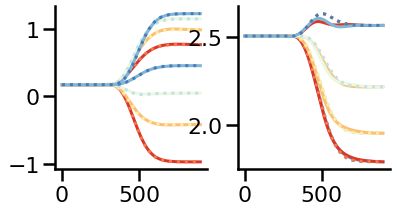

In [17]:
fig, ax = plt.subplots(1,2, figsize=(6,3))
for i in range(8):
    ax[0].plot(x_trj_new[i,:,-4])
    ax[1].plot(x_trj_new[i,:,-3])
    ax[0].plot(target_trj[i,:,0],":")
    ax[1].plot(target_trj[i,:,1],":")
    
sns.despine()

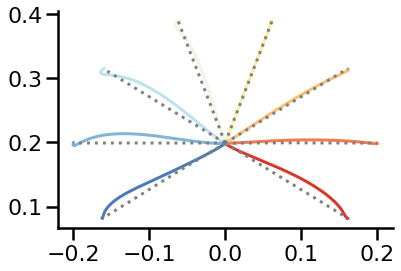

In [18]:
for i in range(8):
    plt.plot(y_trj[i,:,0],y_trj[i,:,1])
    plt.plot(y_target[i,:,0], y_target[i,:,1], ":",color='gray')
sns.despine()

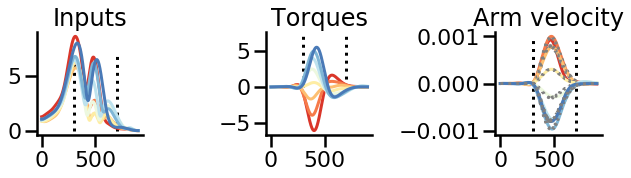

In [19]:
f, ax = plt.subplots(1, 3, figsize=(9,3))

for i in range(8):
    ax[0].plot(np.linalg.norm(u_trj_new[i], axis=-1))
    ax[1].plot(x_trj_new[i,:,0])
    ax[2].plot(np.diff(y_trj[i,:,0]))
    ax[2].plot(np.diff(y_target[i,:,0]), ":", color='gray')
    
for i in range(2):
    ax[i].vlines(300, 0, 7,linestyles=":")
    ax[i].vlines(700, 0, 7,linestyles=":")
    
i = 2
ax[i].vlines(300, -0.001, 0.001,linestyles=":")
ax[i].vlines(700, -0.001, 0.001,linestyles=":")

    
ax[0].set_title("Inputs")
ax[1].set_title("Torques")
ax[2].set_title("Arm velocity")
f.tight_layout()
sns.despine()

In [20]:
# Less prep. input actually. Want higher controls penalty?
np.linalg.norm(u_trj_new[:,:300]) / np.linalg.norm(u_trj_new[:,300:600])

DeviceArray(0.763232, dtype=float32)

## Compound reaches

Reach there and back

In [21]:
prep = d['states'][:,0,:2][:,None].repeat(300, 1)
move = interp1d(np.arange(60), d['states'][:,:,:2], axis=1, fill_value='extrapolate')(np.arange(0, 60, 0.1))
target_trj = np.concatenate((prep, move[:,:-150], move[:,::-1]),1)
y_target = arm_model.get_position_batch(target_trj)
#plt.plot(target_t)

In [22]:
lmbda = 1e-5
regu = 0
steps = 2
t0 = time.time()
x_trj_new, u_trj_new, cost_trace = run_ilqr_batch(x0, target_trj, None, steps, regu, lmbda)
y_trj = arm_model.get_position_batch(x_trj_new[:,:,-4:-2]) 
t1 = time.time()
print(f"{t1-t0:1.0f}") # 1 minute per step

103


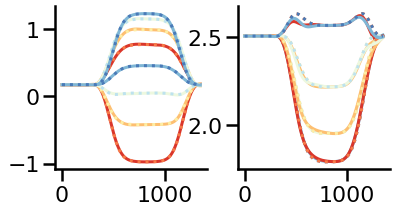

In [23]:
fig, ax = plt.subplots(1,2, figsize=(6,3))
for i in range(8):
    ax[0].plot(x_trj_new[i,:,-4])
    ax[1].plot(x_trj_new[i,:,-3])
    ax[0].plot(target_trj[i,:,0],":")
    ax[1].plot(target_trj[i,:,1],":")
    
sns.despine()

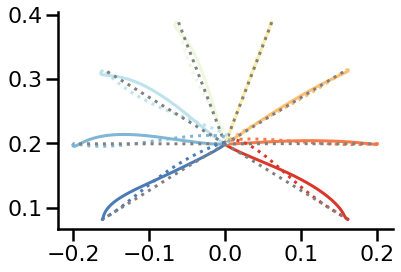

In [24]:
for i in range(8):
    plt.plot(y_trj[i, :-600, 0],y_trj[i,:-600,1])
for i in range(8):
    plt.plot(y_trj[i, -600:, 0],y_trj[i,-600:,1], ":")
    plt.plot(y_target[i,:-600,0], y_target[i,:-600,1], ":",color='gray')
sns.despine()

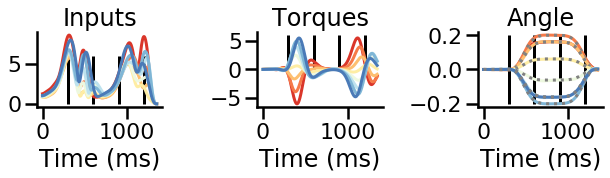

In [25]:
f, ax = plt.subplots(1,3, figsize=(9,3))
for i in range(8):
    ax[0].plot(np.linalg.norm(u_trj_new[i], axis=1))
    ax[1].plot(x_trj_new[i,:,0])
    ax[2].plot(y_trj[i,:,0])
    ax[2].plot(y_target[i,:,0], ":", color='gray')

for j in range(3):
    ax[j].set_xlabel("Time (ms)")
    
    
for j in range(2):
    ax[j].vlines(300, 0, 6)
    ax[j].vlines(600, 0, 6)
    ax[j].vlines(900, 0, 6)
    ax[j].vlines(1200, 0, 6)
    
j = 2
ax[j].vlines(300, -0.2, .2)
ax[j].vlines(600, -.2, .2)
ax[j].vlines(900, -.2, .2)
ax[j].vlines(1200, -.2, .2)


ax[0].set_title("Inputs")
ax[1].set_title("Torques")
ax[2].set_title("Angle")
f.tight_layout()
sns.despine()